### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Processing MCMC

In [1]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
#%load_ext autoreload
%autoreload 2
import functions
#%run ./loop_showcase_functions.ipynb  # Contains project specific functions
    
sys.path.append('../../MODFLOW_Tools')    
logfunc = lambda e: np.log10(e)

C:\Users\19904604\AppData\Local\Temp\ipykernel_24940\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Plotting routines loaded!


In [2]:
# Get times
data_set = pd.read_csv('../modelfiles/ref_past.csv', header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

data_set = pd.read_csv('../modelfiles/ref_future.csv', header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

#### Plot parameter estimates

In [3]:
# Load DREAM results
pickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)
dream_pars_0 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)
dream_pars_1 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)
dream_pars_2 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)
dream_pars_3 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)
dream_pars_4 = pickle.load(pickleoff)
pickleoff.close()

In [4]:
dream_pars = [dream_pars_0, dream_pars_1, dream_pars_2, dream_pars_3, dream_pars_4]
dream_pars = np.array(dream_pars) #(5, 122, 13)

npars, nchains, nburn = dream_pars.shape[2], dream_pars.shape[0], 100

In [5]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[:,1:]
#n = int(B.shape[0]/nchains)
#A = B.reshape((n, nchains, npars))
#B.shape

In [6]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

(-250.0, 0.0)

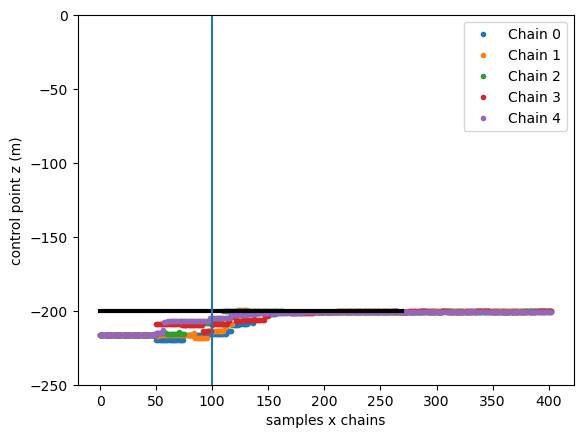

In [7]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(dream_pars[j,:,i], 'o',ms=3)
plt.plot((0, 269),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [20]:
pickleoff = open('../results/reference.pkl','rb')
hk_ref, vk_ref, ss_ref, sy_ref = pickle.load(pickleoff)
pickleoff.close()
cp_ref = -200

pickleoff = open('../results/MCMC.pkl','rb')
Min, Mean, Max = pickle.load(pickleoff)
pickleoff.close()

In [21]:
hk_ref, vk_ref, ss_ref, sy_ref

for i in vk_ref: print(logfunc(i))

-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813


### Linear

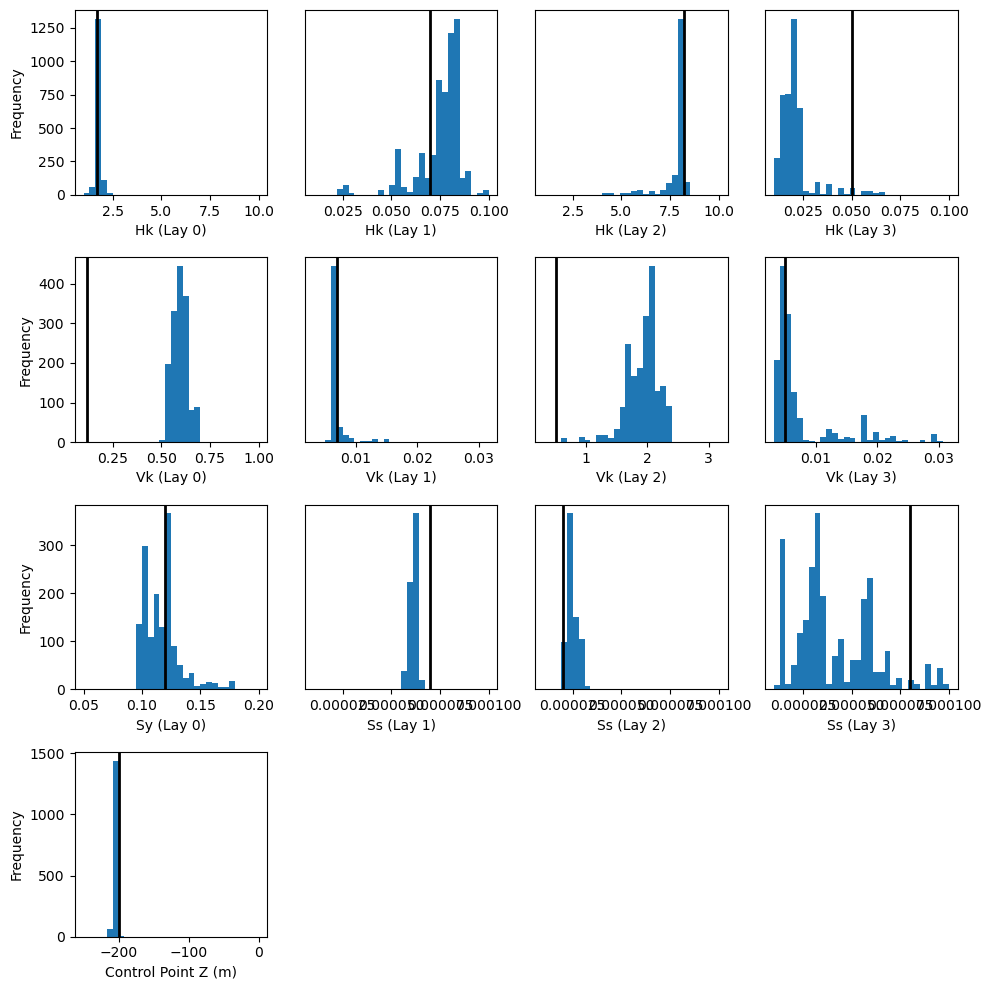

In [30]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    n = i # parameter number
    ax = plt.subplot(4,4,i+1)
    ax.hist(dream_pars[:,nburn:,i].flatten(), bins=30, range = (Min[n],Max[n]))
    plt.axvline(hk_ref[i], color = 'black', lw = 2)
    ax.set_xlabel(f'Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    n = i+4 # parameter number
    ax = plt.subplot(4,4,i+5)
    ax.hist(dream_pars[:, nburn:,i+4].flatten(), bins=30, range = (Min[n],Max[n]))
    plt.axvline(vk_ref[i], color = 'black', lw = 2)
    ax.set_xlabel(f'Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    if i != 0: ax.set_yticks([])
        
# Sy
n = 11 # parameter number
ax = plt.subplot(4,4,9)
ax.hist(dream_pars[:, nburn:,11].flatten(), bins=30, range = (Min[n],Max[n]))
plt.axvline(sy_ref[0], color = 'black', lw = 2)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
#ax.set_xlim([Min[n], Max[n]])
#ax.set_ylim([0,500])

#Ss
for i in range(3):
    n = i+8 # parameter number
    ax = plt.subplot(4,4,i+10)
    ax.hist(dream_pars[:, nburn:,i+8].flatten(), bins=30, range = (Min[n],Max[n]))
    plt.axvline(ss_ref[i+1], color = 'black', lw = 2)
    ax.set_xlabel(f'Ss (Lay {i+1})')
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    ax.set_yticks([])


if npars == 13:
    # CPz   
    n = 12 
    ax = plt.subplot(4,4,13)    
    ax.hist(dream_pars[:, nburn:,-1].flatten(), bins=30, range = (Min[n],Max[n]))
    plt.axvline(cp_ref, color = 'black', lw = 2)
    ax.set_xlabel('Control Point Z (m)')
    ax.set_ylabel('Frequency')
    #ax.set_xlim([Min[n], Max[n]])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/parameters', dpi=450) 

### Log

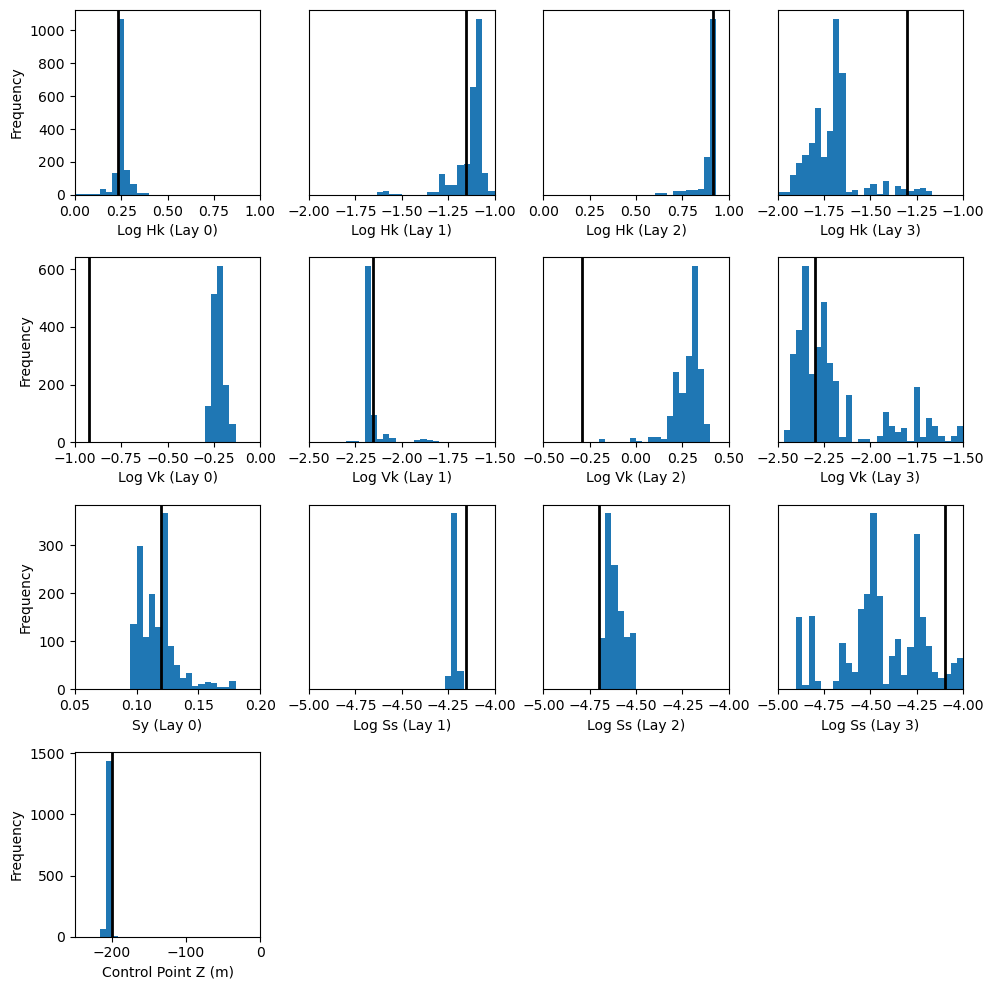

In [38]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    n = i # parameter number
    ax = plt.subplot(4,4,i+1)
    ax.hist(logfunc(dream_pars[:,nburn:,i]).flatten(), bins=30, range = (logfunc(Min[n]),logfunc(Max[n])))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    #ax.set_ylim([0,500])
    ax.set_xlim([logfunc(Min[n]), logfunc(Max[n])])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    n = i+4 # parameter number
    ax = plt.subplot(4,4,i+5)
    ax.hist(logfunc(dream_pars[:, nburn:,i+4]).flatten(), bins=30, range = (logfunc(Min[n]),logfunc(Max[n])))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    #ax.set_ylim([0,500])
    ax.set_xlim([logfunc(Min[n]), logfunc(Max[n])])
    if i != 0: ax.set_yticks([])
        
# Sy
n = 11 # parameter number
ax = plt.subplot(4,4,9)
ax.hist(dream_pars[:, nburn:,11].flatten(), bins=30, range = (Min[n],Max[n]))
plt.axvline(sy_ref[0], color = 'black', lw = 2)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([Min[n], Max[n]])
#ax.set_ylim([0,500])

#Ss
for i in range(3):
    n = i+8 # parameter number
    ax = plt.subplot(4,4,i+10)
    ax.hist(logfunc(dream_pars[:, nburn:,i+8]).flatten(), bins=30, range = (logfunc(Min[n]),logfunc(Max[n])))
    plt.axvline(logfunc(ss_ref[i+1]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    #ax.set_ylim([0,500])
    ax.set_xlim([logfunc(Min[n]), logfunc(Max[n])])
    ax.set_yticks([])


if npars == 13:
    # CPz   
    n = 12 
    ax = plt.subplot(4,4,13)    
    ax.hist(dream_pars[:, nburn:,-1].flatten(), bins=30, range = (Min[n],Max[n]))
    plt.axvline(cp_ref, color = 'black', lw = 2)
    ax.set_xlabel('Control Point Z (m)')
    ax.set_ylabel('Frequency')
    ax.set_xlim([Min[n], Max[n]])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/parameters_log', dpi=450) 

(-5.0, 1.5)

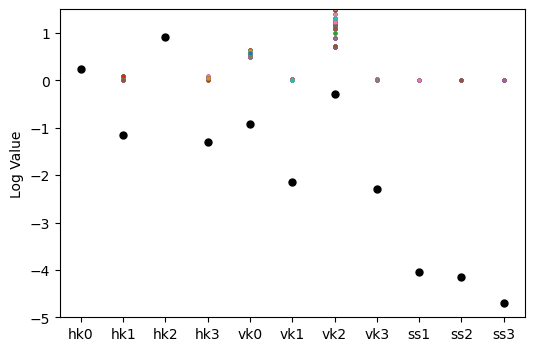

In [23]:
ref = hk_ref + vk_ref + ss_ref
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(169 - nburn):        
            ax.plot(j, dream_pars[k][i][j],'o', ms = 2.)

for j in range(11):
    ax.plot(j, logfunc(ref[j]), 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,11,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [24]:
# Get times
data_set = pd.read_csv('../modelfiles/ref_past.csv', header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

data_set = pd.read_csv('../modelfiles/ref_future.csv', header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [25]:
# Load REFERENCE results
pickleoff = open('../results/ref_past.pkl','rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

pickleoff = open('../results/ref_future.pkl','rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

pickleoff = open('../results/dream_results.pkl','rb') # dream_results (105, 5, 3, 42)
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

In [14]:
dream_results.shape  #(70, 5, 3, 42)

(1010, 5, 3, 42)

### Plot reality vs predicted

In [15]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

dream_results shape (1010, 5, 3, 42)
ref_results shape (5, 3, 42)


In [16]:
dream_results_0 = np.nanpercentile(dream_results, 0, axis=0) 
dream_results_100 = np.nanpercentile(dream_results, 100, axis=0) 

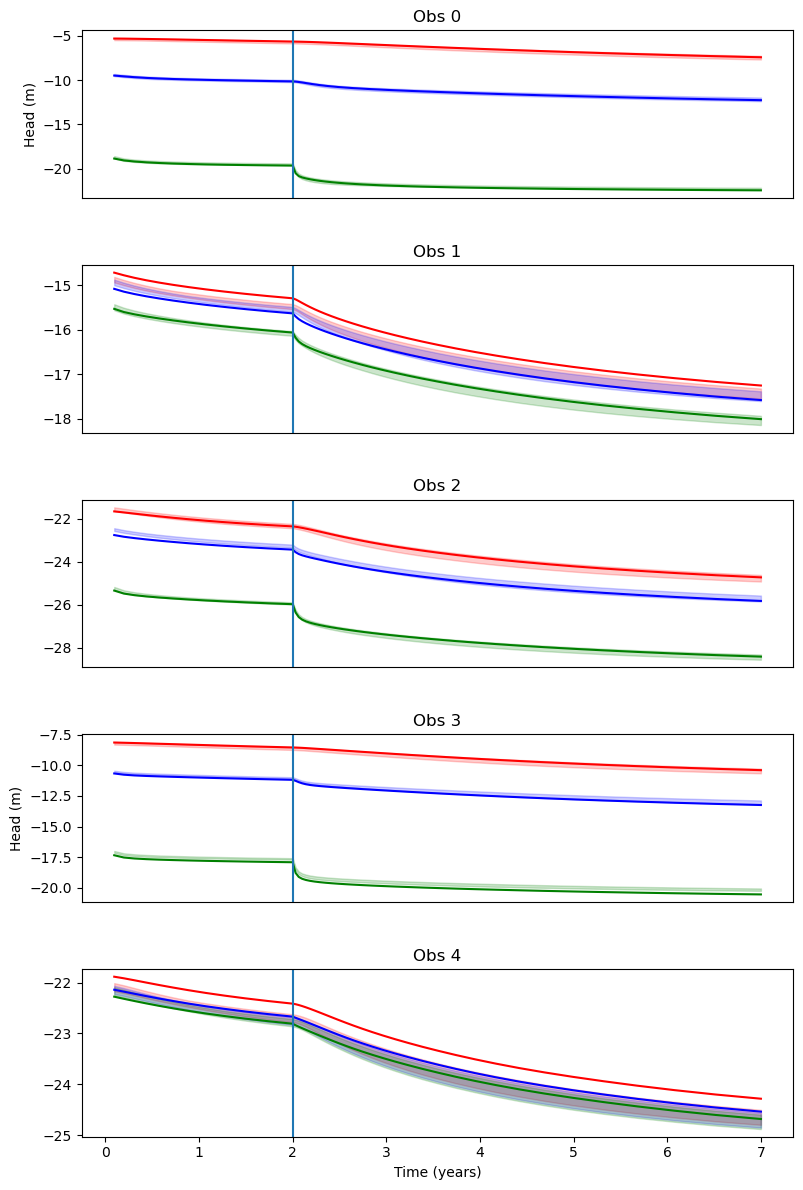

In [17]:
fig = plt.figure(figsize=(8,12))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        ax.fill_between(times, dream_results_0[j, k], dream_results_100[j, k], color = colors[k], alpha = 0.2)        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = colors[k])
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if j == 0 or j == 3 or j == 6: ax.set_ylabel('Head (m)', size = 10)
    ax.axvline(2)
    #ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()
fig.savefig('../figures/predictions', dpi=450) 

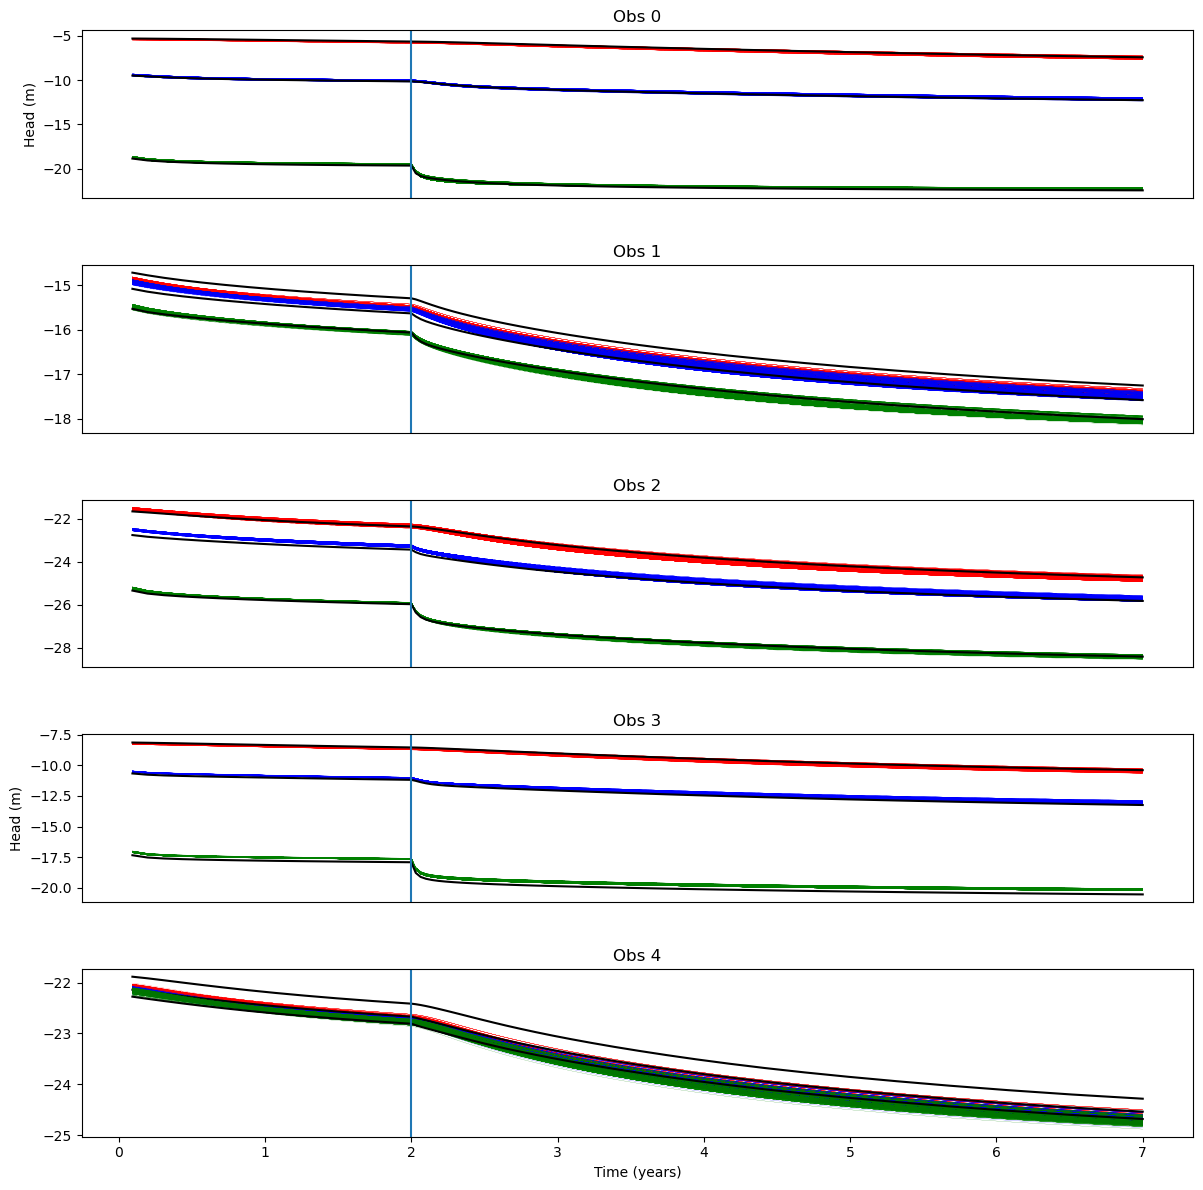

In [18]:
fig = plt.figure(figsize=(12,12))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if j == 0 or j == 3 or j == 6: ax.set_ylabel('Head (m)', size = 10)
    ax.axvline(2)
    #ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

NameError: name 'P' is not defined

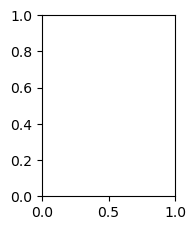

In [19]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""